# `pyotc` Demo

This notebook demonstrates how to use the `pyotc` library to compute the Optimal Transition Coupling (OTC) between two Markov chains.

While OTC can be applied to any pair of Markov chains, one of its most prominent applications—introduced in [Alignment and comparison of directed networks via transition couplings of random walks](https://academic.oup.com/jrsssb/article-abstract/87/1/186/7754547?redirectedFrom=fulltext)—is NetOTC, which focuses on comparing two graphs.

In this notebook, we demonstrate how to use `pyotc` including:
1. Convert two graphs into their corresponding Markov chains, and
2. Compute the OTC between them.


## 1. Import Libraries

We start by importing the necessary libraries, including `pyotc` for computing optimal transition couplings and `networkx` for working with graph structures.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import sys
import os

sys.path.append(os.path.abspath("../src"))

from pyotc.otc_backend.policy_iteration.dense.exact import exact_otc
from pyotc.otc_backend.graph.utils import adj_to_trans, get_degree_cost
from pyotc.examples.stochastic_block_model import stochastic_block_model

## 2. Load and Visualize Example Graphs

In this example, we generate two random graphs using the Stochastic Block Model (SBM).
These graphs serve as input for computing the Optimal Transition Coupling.

In [3]:
# Seed number
np.random.seed(1)

# Generate two stochastic block model graphs with 4 blocks, each containing 5 nodes
m = 5
A1 = stochastic_block_model(
    (m, m, m, m),
    np.array(
        [
            [0.9, 0.1, 0.1, 0.1],
            [0.1, 0.9, 0.1, 0.1],
            [0.1, 0.1, 0.9, 0.1],
            [0.1, 0.1, 0.1, 0.9],
        ]
    ),
)

A2 = stochastic_block_model(
    (m, m, m, m),
    np.array(
        [
            [0.9, 0.1, 0.1, 0.1],
            [0.1, 0.9, 0.1, 0.1],
            [0.1, 0.1, 0.9, 0.1],
            [0.1, 0.1, 0.1, 0.9],
        ]
    ),
)

We also visualize the two graphs to provide an intuitive understanding of their structure before performing the OTC computation.

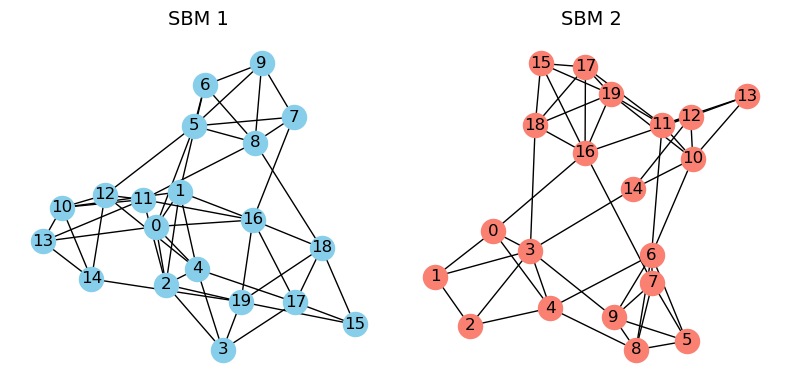

In [4]:
G1 = nx.from_numpy_array(A1)
G2 = nx.from_numpy_array(A2)

plt.figure(figsize=(8, 4))

# Plot left graph
plt.subplot(1, 2, 1)
nx.draw(G1, with_labels=True, node_color="skyblue", arrows=True)
plt.title("SBM 1", fontsize=14)

# Plot right graph
plt.subplot(1, 2, 2)
nx.draw(G2, with_labels=True, node_color="salmon", arrows=True)
plt.title("SBM 2", fontsize=14)

plt.tight_layout()
plt.show()

## 3. Convert Adjacency Matrices to Transition Matrices


We convert each graph's adjacency matrix into a transition matrix that defines a Markov chain over the graph.

For a node $u$, we may define the transition probability to node $u'$ as:

$$
P(u' \mid u) = \frac{w(u, u')}{\deg(u)}.
$$

This transformation is implemented via the `adj_to_trans()` function from `pyotc`.

In [5]:
P1 = adj_to_trans(A1)
P2 = adj_to_trans(A2)

## 4. Define Cost Function

The cost function $c(u, v)$ quantifies the similarity between nodes $u$ and $v$ across the two graphs. Different types of cost functions can be used depending on the application.

In this example, we use a degree-based cost:

$$
c(u, v) = (\deg(u) - \deg(v))^2.
$$

This is implemented via the `get_degree_cost()` function in `pyotc`. For other cost function options and examples, see Section 4.2 of [Alignment and comparison of directed networks via transition couplings of random walks](https://academic.oup.com/jrsssb/article-abstract/87/1/186/7754547?redirectedFrom=fulltext).

In [6]:
# Obtain degree based costs: cost matrix of shape (n1, n2) with squared degree differences.
c = get_degree_cost(A1, A2)

## 5. Solve OTC Problem

With the two transition matrices $P1, P2$ and the cost matrix $c$, we can now solve the Optimal Transition Coupling (OTC) problem.

The goal is to find a transition coupling between the two Markov chains that minimizes the expected cost.
This is done using the `exact_otc()` function in `pyotc`, which returns the optimal cost and optimal transition coupling.


### Function Input

The `exact_otc` function takes five inputs:

- `Px` and `Py`: two transition matrices
- `c`: cost function
- `stat_dist` (optional): method for computing the stationary distribution (default: `best`)
- `max_iter` (optional): maximum number of iterations for convergence (default: 100)

Below, we provide a brief overview of the `stat_dist` and `max_iter` parameters.

`max_iter`    

Sets the maximum number of iterations for convergence in computing the transition coupling. In practice, `exact_otc` usually converges within about 10 iterations, so the default value of 100 is typically sufficient.

`stat_dist`  

Specifies how the stationary distribution of the transition coupling should be computed. Options include:

- `'best'` (default)
- `'eigen'`
- `'iterative'`
- `None`

The `exact_otc` algorithm operates in two stages:
1. Compute the transition coupling $R$ using alternating updates (`tce` and `tci`).
2. Compute the stationary distribution of the optimal transition coupling $R$ computed in stage 1.

Because the second stage can be computationally expensive, if you're only interested in the transport cost (i.e., `exp_cost`) and not in node or edge alignment, you can set `stat_dist=None` to skip this step and save time and memory.

If the stationary distribution is needed, you can choose among `'best'`, `'eigen'`, or `'iterative'`. 

The optimal transition coupling $R$ may not always have a unique stationary distribution. Ideally, we want a stationary distribution of $R$ that corresponds to the minimum transport cost. The `best` option ensures this by solving a separate linear programming (LP) problem to find the cost-minimzing stationary distribution. While accurate, this method can be computationally expensive in terms of time and memory.

The `'eigen'` and `'iterative'` options offer faster alternatives. They return a valid stationary distribution of $R$, though not necessarily the one that minimizes the transport cost:
  - `'eigen'`: uses eigenvalue decomposition
  - `'iterative'`: uses power iteration

If $R$ forms an **ergodic Markov chain**, the stationary distribution is guaranteed to be unique, and all methods will yield the same result.

In [7]:
exp_cost, R, stat_dist = exact_otc(P1, P2, c, stat_dist="best")
print("\nExact OTC cost between SBM1 and SBM2:", exp_cost)

Starting exact_otc_dense...
Iteration: 0
Computing exact TCE...
Computing exact TCI...
Iteration: 1
Computing exact TCE...
Computing exact TCI...
Iteration: 2
Computing exact TCE...
Computing exact TCI...
Iteration: 3
Computing exact TCE...
Computing exact TCI...
Iteration: 4
Computing exact TCE...
Computing exact TCI...
Iteration: 5
Computing exact TCE...
Computing exact TCI...
Convergence reached in 6 iterations. Computing stationary distribution...
[exact_otc] Finished. Total time elapsed: 1.173 seconds.

Exact OTC cost between SBM1 and SBM2: 0.7000538762516204


### Function Output

The `exact_otc` function returns three outputs:
1. **`exp_cost` (float)**     
    The expected transport cost under the optimal transition coupling. This value represents the minimum cost and serves as a quantitative measure of the difference between two graphs, making it useful for graph comparison tasks.
2. **`R` (np.ndarray)**  
    The optimal transition coupling matrix with shape $(n_1\times n_2, n_1 \times n_2)$, where $n_1$ and $n_2$ are the number of vertices in the two graphs.
3. **`stat_dist` (np.ndarray)**  
    The stationary distribution of the optimal transition coupling with shape $(n_1, n_2)$. This matrix provides a soft, probabilistic alignment between the nodes of the two graphs.

In addition to node-level alignment, edge-level alignment can also be computed. The mass assigned to a pair of edges $(x_1, x_2)$ and $(y_1, y_2)$ is given by: 

$$
\text{stat\_dist}(x_1, y_1) \times R((x_1, y_1),\ (x_2, y_2))
$$

For further details, see Section 4 of the paper:  
[Alignment and comparison of directed networks via transition couplings of random walks](https://academic.oup.com/jrsssb/article-abstract/87/1/186/7754547?redirectedFrom=fulltext).
